### 1. Sekcja odczytywania danych, określania typów danych cech.

In [18]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import timeit





### Aggregator rzadkich klas danej zmienej kategorycznej.

In [19]:

class RareClassAggregator(TransformerMixin, BaseEstimator):
    def __init__(self,  q:float = 0.1) -> None:
        assert isinstance(q, float) and 0< q <1, "Argument 'q' musi być liczbą zmiennoprzecinkową z przedziału (0;1)"
    
        self.q: float = q


    def validate_X(self, X:pd.DataFrame, cat_features:list[str]) -> None:
        "Sprawdza czy x spełnia warunki"
        assert isinstance(X, pd.DataFrame), "Argument 'X' musi być instancją klasy pd.DataFrame!"

        assert isinstance(self.cat_features, list)

        assert set(cat_features).issubset(self.cat_features), "Zbyt wiele zmiennych kategorycznych przekazałeś!"
        assert len(cat_features) > 0, "Przekazałeś pusty zbiór cech kategorycznych!"




    def fit(self, X:pd.DataFrame, y: None = None, cat_features:list[str] = [] ) -> "RareClassAggregator":
        """Wylicz próg częstowliwościowy dla zmiennej kategorycznej 'cat_feature'.
        Opis argumentów:
        ---------
        X:pd.DataFrame - Ramka danych typu pandas, która zawiera ceche 'cat_feature', której rzadkie cechy chcemy połączyć w jedną klase.
        y:pd.DataFrame - Argument nieuzywany, służy do zachowania spójności transformatotów.
        cat_features:list[str] - Lista nazw zmiennych kategorycznych.
        """

        #'y' musi być stale równy None. Nie jest on potrzebny dla tego estimatora.
        if y is not None:
            raise ValueError("Argument 'y' musi być zawsze ustawiony na wartość None!")
        
        self.X_train: pd.DataFrame = X #Zdefiniuj zbiór treningowy.
        self.cat_features = cat_features
        
        self.validate_X(X = X, cat_features = self.cat_features) #Sprawx, czy argument X spełnia podstawowe założenia.


      
        self.freq_thresholds:dict[str, float] = {} #Tabela przechowująca wszystkie progi częstotliwościowe dla każdej cechy kategorycznej
        self.cross_tabs: list[pd.Series] = {} #Słownik służący do przechowywania tabeli krzyżowych każdej zmiennej kategorycznej.

        for cat_feature in self.cat_features:
            class_crosstab:pd.Series = ( self.X_train[cat_feature]. #Znajdź tabelę krzyżową dla zmiennej kategorycznej 'cat_feature'
                                         value_counts(normalize = True, sort = True))

            self.freq_thresholds[cat_feature] = class_crosstab.quantile(q = self.q) #Wylicz próg częstotliwościowy dla zmiennej 'cat_feature'

            self.cross_tabs[cat_feature] = class_crosstab

        
        return self


    def transform(self, X:pd.DataFrame, cat_features:list[str]) -> pd.DataFrame:
        """Transformuje ramkę danych X, agregując rzadkie klasy zmiennej kategorycznej 'cat_feature' """
        self.validate_X(X = X, cat_features = cat_features) #Upewnij się, że X jest ramką danych oraz, że cat_features jest NIEPUSTYM podzbiorem zbioru cech X.


        for cat_feature in cat_features:
            class_freqtable:pd.Series =  X[cat_feature].value_counts(normalize = True, sort = False) #Wyestymuj znormalizowaną tabelę krzyżową.


            #Stwórz agregowaną kolumnę cechy kategorycznej.
            aggregated_col:pd.Series =  X[cat_feature].apply(func = lambda v:   v if class_freqtable[v] >= self.freq_thresholds[cat_feature] else "Other").astype(dtype = "string")
                                        
            

            X.loc[:, cat_feature]  = aggregated_col
     
        return X
    

   

    def get_feature_names_out(self,) -> None:
        pass
    

### Podrasowany SequentialFeatureSelector z wewnętrznym mechanizmem OHE dla zmiennych kategorycznych.

In [20]:
class WrappedSequentialFeatureSelection(SFS):
    def __init__(self,  cat_vars:list[str],**kwargs) -> None:
        """"
        Opis argumentów: \n
        ---------
        cat_vars:list[str] - Lista ciągów znaków, które identyfikują zmienne kategoryczne \n

        """""""""
        super().__init__(**kwargs)
        
        self.cat_vars:np.ndarray[str] = cat_vars #Indeksy wszystkich zmiennych kategorycznych przyszłej ramki danych X.




    def convert_to_numpy(self, X:pd.DataFrame):
        #The method converts X to numpy.array after categorical variables of X are Labeled.
        for cat_var in self.cat_vars:
            X[cat_var] = LabelEncoder().fit_transform(y = X[cat_var])
    

        return np.array(X)

        
    def fit(self, X:pd.DataFrame, y: np.ndarray):
        #Jeżeli X jest ramką danych, przekształć X do tablicy numpy, zachowując indeksy zmiennych kategorycznych.
        if isinstance(X, pd.DataFrame):
            features = X.columns.to_list()

            self.cat_vars_idx:list[int] = [features.index(cat_feat) for cat_feat in self.cat_vars]
            
            X = self.convert_to_numpy(X = X.copy())
    
        super().fit(X = X, y = y)

    def return_cat_var_indx(self) -> list[int]:
        return self.cat_vars_idx
        

        

    def _get_best_new_feature_score(self, estimator, X:np.ndarray, y:np.ndarray, cv:int, current_mask):
        # Return the best new feature and its score to add to the current_mask,
        # i.e. return the best new feature and its score to add (resp. remove)
        # when doing forward selection (resp. backward selection).
        # Feature will be added if the current score and past score are greater
        # than tol when n_feature is auto,
  
        candidate_feature_indices = np.flatnonzero(~current_mask) #Indeksy zmiennych, które nie zostały jeszcze wybrane.
        scores = {}
    
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy() #Tworzymy kopię tablicy maskowej cech, które już wybraliśmy.
            candidate_mask[feature_idx] = True #W miejsce feature_indx wstawiamy True. Udajemy, że wybraliśmy cechę feature_indx.

            candidate_cat_vars:list[int] = [i for i in self.cat_vars_idx if candidate_mask[i] == True] #Indeksy zmiennych kategorycznych kandydatów.
            candidate_no_cat_vars:list[int] =[i for i in np.flatnonzero(candidate_mask) if i not in self.cat_vars_idx ]  #Indeksy zmiennych niekategorycznych kandydatów.



            #Kodowator OHE, który przekształca na gorąco zmienne kategoryczne, a pozostałe zmienne "transformuje" w sposób identycznościowy.
            var_transformer = ColumnTransformer(transformers = [("OHE", OneHotEncoder(sparse_output = False), candidate_cat_vars),
                                                    ("Identity", FunctionTransformer(), candidate_no_cat_vars)], 
                                    remainder = "drop")
        
            X_new = var_transformer.fit_transform(X = X)

        
            scores[feature_idx] = cross_val_score(
                estimator,
                X_new,
                y,
                cv=cv,
                scoring=self.scoring,
                n_jobs=self.n_jobs,
            ).mean()


        new_feature_idx = max(scores, key=lambda feature_idx: scores[feature_idx])

        
        return new_feature_idx, scores[new_feature_idx]
    

### Przygotowanie metody porównaczej.


In [21]:
from sklearn.metrics import make_scorer

class ModelsComparisom():
    def __init__(self,  Filename:str, target_var:str, dtypes:dict[str, "datatype"], Models:dict[str, "estimator"], Models_hipparams:dict[str, dict],
                 n_splits:int = 5, train_size:float = 0.8, test_size:float = 0.2, bins:list[int] = [150, 250], show_plots:bool = True) -> None:
        """Konstruktor klasy, która trenuje modele. 
        Opis argumentów konstruktora:
        ---------
        Filename: str - Nazwa pliku, w której zawarta jest ramka danych typu pandas, która przechowuje zmienne objaśniające i zmienną objaśnianą. \n
        target_var:str - Nazwa zmiennej objaśnianej. \n

        dtypes:dict[str, "datatype"] - Typ danych każdej kolumny w pliku. \n

        Models:dict[str, "Estimator"] - Słownik, którego wartościami są instancje modeli, które chcemy wytrenować. Kluczami są umowne nazwy modeli. \n
        Models_hipparams:dict[str, dict] - Słownik, którego kluczami są umowne nazwy modeli, a którego wartościami są siatki parametrów danego modelu. \n

        n_splits:int - Liczba podziałów na zbiór treningowy i testowy. \n
        train_size:float - Odsetek obserwacji treningowych. \n
        test_size:float - Odsetek obserwacji testowych. \n

        bins:list[int]  - Wartości brzegowe dla dyskretyzacji zmiennej docelowej.
        show_plots: bool - Czy chcesz, aby pokazywano wykresy.

        ---------
        """
     
        self.dtypes:dict[str, "datatype"] = dtypes

        self.Dataset:pd.DataFrame = self.ReadDataFrame(filename = Filename, sep = ';', dec_sep = ',') 
        self.features:list[str] = self.Dataset.columns
 
        
        self.Cat_features:list[str] = [feature for feature in self.features if dtypes[feature] == "string"]
        self.Num_features:list[str] =  list(self.Dataset.select_dtypes(include = "number").columns)
    
     
        self.target_var:str = target_var
        self.bins:list[int] = bins

        self.Cat_predictors:list[str] = []
        self.Num_predictors:list[str] = []
        self.PCA_predictors:list[str] = []

        self.Models:dict[str, "estimator"] = Models
        self.Models_hipparams:dict[str, dict] = Models_hipparams

        self.n_splits:int = n_splits
        self.train_size:float = train_size
        self.test_size:float = test_size

        self.show_plots:bool = show_plots


        self.PrzygotujRamkiPorownawcze()
        self.PrzygotujRamkiCzasowe()
        

    def ReadDataFrame(self, filename:str, 
                      sep:str =';', dec_sep:str =',') -> pd.DataFrame:
        """Odczytuje plik o nazwie filename i wprowadza dane z pliku do ramki danych."""
     
    
        Dataset:pd.DataFrame = pd.read_csv(filename,
                            sep=sep, dtype = self.dtypes, decimal = dec_sep) #Wczytaj plik z danymi.


        return Dataset
    


    def PlotBarPlot(self, FreqTable:pd.Series, cat_feature:str, Showxlabels:bool = False) -> None:
        """Funkcja rysuje histogram na bazie tabelki histogramowej. 
        1) FreqTable  - Tabela częstotliwości kategori danej zmiennej kategorycznej
        2) CatFeature  - Cecha kategoryczna, której histogram chcemy narysować.
        3) Showxlabel - Zmienna typu bool. Jeżeli ustawiona na True, to etykietki osi Ox są wyświetlane."""
        
        plt.figure(figsize = (10,5)) #Stwórz płótno, na którym  będzie rysowany wykres
    
        axes = sns.barplot(x = FreqTable.index, y = FreqTable.values)


        axes.set_ylabel(f"Częstość klasy") #Ustaw etykietke pionowej osi.

        axes.set_xticklabels([]) #Usuń etykiety tyknięć na osi Ox.
        axes.spines[["top", "right"]].set_visible(False)

        axes.set_title(f"Histogram klas cechy {cat_feature}") #Ustaw tytuł wykresu.

        axes.set_ylim(0, 1.05*np.max(FreqTable))

        if Showxlabels == True:
            axes.set_xticklabels(labels = FreqTable.index)
            


    def DeleteFutileColsAndObs(self) -> pd.DataFrame:
        """Funkcja usuwa quasi-identyfikator zmienną oraz jedną obserwację, która zawiera klasę, która występuje tylko raz."""

        self.Dataset.drop(columns = ["Model"], inplace = True)

        self.Dataset = self.Dataset.query('`Fuel Type` != "N"')

   
    def ComputeAndDrawCorrelationMatrix(self,) -> None:
        """Funkcja wylicza macierz korelaji dla zmiennych z listy FloatFeatures. Ponadto, rysuje tę macierz korelacji na wykresie, aby można
        było sobie uzmysłowić relacje między zmiennymi"""

        CorrMatrix:pd.DataFrame =  self.Dataset[self.Num_features].corr(method = "pearson")

        plt.figure(figsize=(8, 6))

        sns.heatmap(CorrMatrix, annot=True, cmap='magma', vmin=-1, vmax=1)
        plt.title('Macierz korelacji dla zmiennych ciągłych')
        plt.show()




    def DeleteFutileColsAndObs(self) -> None:
        """Funkcja usuwa quasi-identyfikator zmienną oraz jedną obserwację, która zawiera klasę, która występuje tylko raz."""

        self.Dataset.drop(columns = ["Model"], inplace = True)

        self.Dataset = self.Dataset.query('`Fuel Type` != "N"')


    def NarysujGęstości(self, Condition:str | None = None) -> None:
        """Ta funkcja rysuje wykresy gęstości prawdopodobieństwa dla zmiennych ciągłych"""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"KDE_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.kdeplot(data = self.Dataset, x = float_feature, ax = axes, hue = Condition)
            axes.set_title(f"Wykres gęstości prawdopodobieństwa dla zmiennej {float_feature}")



    def NarysujPudełko(self, Condition: str | None = None) -> None:
        """Ta funkcja rysuje wykresy pudełkowe dla zmiennych ciągłych.
        1) Dataset - oryginalny zestaw danych.
        2) FloatFeatures - zmienne numeryczne"""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"BOX_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.boxplot(self.Dataset, x = float_feature, hue = Condition)

            axes.set_title(f"Wykres pudełkowy dla zmiennej {float_feature}")


    def NarysujSkrzypce(self,Condition:str | None = None) -> None:
        """Ta funkcja rysuje wykresy skrzypcowe dla zmiennych ciągłych.
        1) Dataset - oryginalny zestaw danych.
        2) FloatFeatures - zmienne numeryczne
        3) Condition = Pewna zmienna kategoryczna, za pomocą której stworzą się warunkowe wykresy skrzypcowe ze względu przynależność do klasy."""

        for float_feature in self.Num_features:
            figure = plt.figure(num = f"VIOLIN_plot_{float_feature}")
            axes = figure.add_subplot()

            sns.violinplot(self.Dataset, x = float_feature, hue = Condition)

            axes.set_title(f"Wykres skrzypcowy dla zmiennej {float_feature}")

            axes.legend([])

            axes.grid(True, alpha = 0.6)
            axes.spines[['top','right']].set_visible(False)


    def NarysujWykresParowy(self,   Condition: str | None = None) -> None:
        """Funkcja rysuje wykres parowy dla wszystkich par zmiennych ciągłych.
        """
        sns.pairplot(self.Dataset, hue = Condition ,diag_kind = "kde")




    def Discretize(self) -> None:
        """Dyskretyzacja zmiennej docelowej."""
        labels:list[int] = [i for i in range(len(self.bins) -1)]
     

        discretized_feature:pd.Series = pd.cut(x = self.Dataset[self.target_var], 
                                    bins = self.bins, 
                                    labels = labels)
        

        self.Dataset[self.target_var_discr] = discretized_feature


    



    def StatystykaOpisowaZmiennych(self) -> None:
        """Metoda przedstawia pewne statystyki dla zmiennych, które pozwolą nam dokonać wyboru predyktorów.
        Opis argumentów:
        ---------
        show_plots: bool - Czy mamy pokazywać wykresy?
        ---------
        """


        # Agregacja rzadkich klas.
        RareClassAggregator_inst = RareClassAggregator(q = 0.15) #Zdefiniuj obiekt klasy RareClassAggregator, który będzie agregował rzadkie klasy każdej cechy.

        RareClassAggregator_inst.fit(X = self.Dataset, y = None,  #Znajdź odpowiednie parametry  estymatora.
                                     cat_features = self.Cat_features)

        self.Dataset:pd.DataFrame = RareClassAggregator_inst.transform(X = self.Dataset, cat_features = self.Cat_features) #Przekształć obecny zbiór danych.

        cross_tabs:list[pd.Series] = RareClassAggregator_inst.cross_tabs #To jest lista zawierająca tablice krzyżowe każdej cechy

        for cat_feature in self.Cat_features:
            cros_tab:pd.Series = cross_tabs[cat_feature]


            if self.show_plots is True:
                self.PlotBarPlot(FreqTable = cros_tab, cat_feature = cat_feature, Showxlabels = False)
            



            
        
        #Kasowanie zbędnej obserwacji oraz quasi-id kolumny
        self.DeleteFutileColsAndObs()

        #Nadaj zdyskretyzowanej zmiennej docelowej nazwę.
        self.target_var_discr = self.target_var +"_disc"

        #Zdyskretyzuj zmienną objaśnianą.
        self.Discretize()

        
        #Narysuj wykresy charakteryzujące (relacje między zmiennymi) oraz (charakterystyki zmiennych).
        #RYSOWANIE MACIERZY KORELACJI DLA ZMIENNYCH NUMERYCZNYCH

        target_var_discr_histogram:pd.Series = self.Dataset[self.target_var_discr].value_counts(normalize = True, sort = False)

        if self.show_plots is True:
            self.ComputeAndDrawCorrelationMatrix()

            #RYSOWANIE WYKRESÓW SKRZYPCOWYCH DLA ZMIENNYCH NUMERYCZNYCH
            self.NarysujSkrzypce()

            #Rysowanie wykresu parowego dla zmiennych numerycznych
            self.NarysujWykresParowy()

            


            self.PlotBarPlot(FreqTable = target_var_discr_histogram,   #Narysuj wykres słupkowy częstotliwości dla zmiennej celu zdyskretyzowanej.
                            cat_feature =  self.target_var_discr, 
                            Showxlabels = False)
            
        
            self.NarysujGęstości(Condition = self.target_var_discr)  #Wykresy gęstości warunkowe
            self.NarysujPudełko(Condition = self.target_var_discr) #Wykresy pudełkowe warunkowe

        
            self.NarysujWykresParowy(Condition = self.target_var_discr)


        #Ustal ostateczny zbiór predyktorów.
        Predictors = ['Make', "Vehicle Class",'Engine Size(L)','Cylinders','Transmission','Fuel Type',"Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                                                                                       "Fuel Consumption Comb (L/100 km)","Fuel Consumption Comb (mpg)"]
      
        #Podziel zbiór predyktorów na zmienne numeryczne oraz zmienne kategoryczne odpowiednio.
        self.Num_predictors:list[str] = [feature for feature in Predictors if self.dtypes[feature] in  [np.float64, np.int16]]
        self.Cat_predictors:list[str] = [feature for feature in Predictors if self.dtypes[feature] == "string"]


        self.PCA_predictors = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)", 
                                                                              "Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
        

        self.unique_categories = [self.Dataset[cat_var].unique() for cat_var in self.Cat_predictors]
       

    def ComputeMetric(self, TrueVSPrediction:pd.DataFrame, metric) -> pd.DataFrame:
        """Funkcja wylicza metrykę dokładności, która stanowi podstawę oceny modeli.
        Opis argumentów:
        ---------
        TrueVSPrediction:pd.DataFrame - Ramka danych zawierająca etykiety prawdziwe oraz etykiety przewidziane. Kolumny tej ramki są indeksowane za pomocą trójki (model_name, split_indx, y_type)

        ---------

        Co funkcja zwraca?
        Ramke danych typu pandas wymiaru (self.n_splits,  len(self.Models)), w której  elementy (i, j) odpowiada wartości metryki dokładności dla i-tego podziału i j-tego modelu.
        """
        Models_name: list[str] = list(self.Models.keys())

        MetricComparison = np.zeros(shape = [self.n_splits, len(Models_name)], 
                                    dtype = np.float64)
        
        for model_indx, model in enumerate(Models_name):
            for i in range(self.n_splits):
                y_true = TrueVSPrediction[(model, i, "True")]
                y_pred = TrueVSPrediction[(model, i, "Pred")]

                perfomance_metric =  metric(y_true = y_true,
                                                    y_pred = y_pred, 
                                                    average = "weighted",
                                                    zero_division = 0)

                MetricComparison[i, model_indx] = perfomance_metric


        return pd.DataFrame(data = MetricComparison, 
                                        columns = list(self.Models.keys()))



   


    def PlotConfussionMatrix(self, type:str = "bez strojenia") -> None:
        """Metoda tworzy macierz pomyłek, którą następnie przedstawia na obrazku jako macierz pomyłek
        Opis argumentów:
        type:str - Typ dopasowania (ze strojeniem lub bez strojenia.)
        ---------
        """
        for model_name in self.Models.keys():
            if type == "bez strojenia":
                y_true:pd.Series = self.FactVsPrediction_untuned[(model_name, 0,  "True")]
                y_predicted:pd.Series = self.FactVsPrediction_untuned[(model_name, 0,  "Pred")]

            elif type == "ze strojeniem":
                y_true:pd.Series = self.FactVsPrediction_tuned[(model_name, 0,  "True")]
                y_predicted:pd.Series = self.FactVsPrediction_tuned[(model_name, 0,  "Pred")]

            elif type == "z wyborem cech":
                y_true:pd.Series = self.FactVsPrediction_FS[(model_name, 0,  "True")]
                y_predicted:pd.Series = self.FactVsPrediction_FS[(model_name, 0,  "Pred")]

            else:
                raise ValueError("Nieprawidłowy rodzaj trenowania. Trenuje się albo bez strojenia albo ze szkoleniem")
            


            axes = plt.figure(num = f"{model_name}_conf_matrix_{type}").add_subplot()


            ConfusionMatrixDisplay.from_predictions(y_true = y_true, y_pred = y_predicted, ax = axes, normalize = "true")
            axes.set_title(f"ConfMatrix dla  modelu {model_name}, wersja {type}")




    def PlotScoresCollectively(self, perfomance_df: pd.DataFrame, metric_name:str, type:str = "bez strojenia") -> None:
        """Metoda na wykresie przedstawia wartości metryki 'metric_name' dla różnych modeli niestrojonych lub strojonych dla różnych podziałów.
        Opis argumentów:
        ---------
        perfomance_df:pd.DataFrame - Ramka danych zawierająca wartości miary dokładności w 'split_indx' podziale dla modelu 'model_name'
        metric_name:str - Nazwa metryki dokładności.
        type:str - Typ dopasowania (strojony lub niestrojony) 
        ---------
        """

        figure = plt.figure()
        axes = figure.add_subplot()
            
        x_values:list[int] = list(range(0, self.n_splits))

        
        for model_name in self.Models.keys():
            axes.plot(x_values, 
                    perfomance_df[model_name])
            
        #Tablica, która przechowuje mediane wartości metryki dokładności w i-tym podziale.
        averages:list[float] = []
            
        for i in range(self.n_splits):
            averages.append(perfomance_df.iloc[i, :].median())
            
        axes.plot(x_values, averages, linestyle = "dashed", linewidth = 2)

        axes.legend(list(self.Models.keys()) +["MetricMedian"])
        axes.set_title(f"Dynamika zmian metryki {metric_name} dla modeli, wersja {type}")

        axes.set_xlabel("Numer iteracji") #Ustaw ładną etykietkę osi Ox
        axes.set_ylabel(f"{metric_name}") #Ustaw ładną etykietkę osi Oy

        axes.set_xticks(x_values) #Ustaw wartości tyknięć na osi Ox
            
        axes.grid(True) #Dodaj linie siatki

        axes.spines[['top','right']].set_visible(False) #Usuń kreskę górną oraz dolną.





    def PorównajZIBeZStrojeniaModel(self, Metric_comparison_untuned:pd.DataFrame, Metric_comparison_tuned:pd.DataFrame, Metric_comparison_fs:pd.DataFrame, metric_name:str,
                    ) -> None:
        """Metoda porównuje wartości miary dokładności dla każdego modelu indywidualnie w wersji bez strojenia i ze strojeniem.

        Opis argumentów:
        ---------
        Metric_comparison_untuned:pd.DataFrame - Ramka danych, która w  komórce [ ('model_name'), ('split_indx')] zawiera wartość miary dokładności dla niestrojonego modelu 'model_name' w 'split_indx' podziale.
        Metric_comparison_tuned:pd.DataFrame - Ramka danych, która w  komórce [ ('model_name'), ('split_indx')] zawiera wartość miary dokładności dla strojonego modelu 'model_name' w 'split_indx' podziale.
        ---------
        """
      
        models_name: list[str] = list(self.Models.keys()) #Znajdź listę nazw modeli.

    

        for model_name in models_name:
            #Stwórz okienko, na którym będzie wyświetlane porównanie między niedostrojonym, a dostrojonym modelem.
            okno: plt.figure = plt.figure( num = f"{model_name} (un)tuned metric comparison for {metric_name}")
            #Stwórz osie.
            osie = okno.add_subplot()

        
            M_untuned:pd.Series = Metric_comparison_untuned[model_name] 
            M_tuned: pd.Series = Metric_comparison_tuned[model_name]
            M_fs:pd.Series = Metric_comparison_fs[model_name]


            osie.boxplot(x = [M_untuned, M_tuned, M_fs], positions = [0, 2, 4])

            osie.legend(["Niedostrojony",'Dostrojony'])
            osie.grid(True)
            osie.spines[['top','right']].set_visible(False)
            osie.set_title(f"Porównanie niestrojonego i strojonego  {model_name}, metryka {metric_name}")


            osie.set_ylabel(f"Wartość metryki {metric_name}")
         


    def PorównajCzasyTrenowania(self, type:str = "bez strojenia"):
        """Ta metoda, dla ustalonego, jednego z trzech, trybów trenowania, wyświetla czasy trenowania różncych algorytmów klasyfikujących."""

        x_axis_values:list[int] = list(range(1, self.n_splits+1)) #Wartości na osi Ox.

        figure  = plt.figure(num = f"Porównanie czasów trenowania, wersja {type}") #Zdefiniuj okno.
        axes = figure.add_subplot() #Zdefiniuj osie.


        if type == "bez strojenia":
            for model_name in self.Models.keys():
                axes.plot(x_axis_values, self.Untuned_train_time[model_name])

        elif type == "ze strojeniem":
            for model_name in self.Models.keys():
                axes.plot(x_axis_values,  self.Tuned_train_time[model_name])

        elif type == "z wyborem cech":
            for model_name in self.Models.keys():
                axes.plot(x_axis_values, self.FS_train_time[model_name])
        else:
            raise ValueError("Błędny tryb trenowania")


        axes.legend(list(self.Models.keys()))
        axes.grid(True)
        axes.spines[["top", "right"]].set_visible(False)

        axes.set_xlabel("Numer podziału")
        axes.set_ylabel('Czas tren.')
        axes.set_title(f"Czas trenowania modeli w milisekundach, wersja {type}")



    

  
    def StworzRamkePorownawcza(self,) -> pd.DataFrame:
        """Funkcja stwarza tabelkę porównawcza, która jest po prostu ramką pandas. Indeksy kolumn są trzypoziomowe. Na najwyższym poziomie jest nazwa modelu, niżej jest
        numer podziału, a na końcu tyb etykiet (prawdziwe etykiety lub przewidywane etykiety).  \n 
        """

        Indeces = pd.MultiIndex.from_product( [list(self.Models.keys()), range(self.n_splits), ["True", "Pred"] ] #Stwórz  hierarchiczny system indeksów dla kolumn.
                                            ,names = ["Model", "iter_no", "y_type"]) #Nadaj poszczególnym poziomom wyjaśnialne i sensowne nazwy.

        return  pd.DataFrame(data = None,  columns = Indeces, dtype = np.int16)


    def PrzygotujRamkiPorownawcze(self,) -> None:
        """Ta metoda dla każdego rodzaju modeli (niestrojony, strojony, strojony+fs) tworzy ramki porównawcze."""

        self.FactVsPrediction_untuned:pd.DataFrame =  self.StworzRamkePorownawcza()
        self.FactVsPrediction_tuned:pd.DataFrame = self.StworzRamkePorownawcza()
        self.FactVsPrediction_FS:pd.DataFrame = self.StworzRamkePorownawcza()


    
    def StworzRamkeCzasowa(self, ) -> pd.DataFrame:
        """"Funkcja tworzy ramkę danych typu pandas, której wartości za indeksowane za pomocą pary (model_name, split_indx).
        W komórce (model_name, split_indx) znajduje się czas wytrenowania modelu model_name w podziale nr split_indx
        """
        
        Col_indeces:list[str] = list(self.Models.keys())
        Row_indeces:list[int] = list(range(self.n_splits))

        return pd.DataFrame(columns = Col_indeces, index = Row_indeces, dtype = np.float64)
    

    def PrzygotujRamkiCzasowe(self, ) -> None:
        """Metoda definiuje trzy ramki czasowe, w których będą przechowywane czasy dopasowania modeli strojonych i niestrojonych"""
        self.Untuned_train_time = self.StworzRamkeCzasowa()
        self.Tuned_train_time = self.StworzRamkeCzasowa()
        self.FS_train_time = self.StworzRamkeCzasowa()




    
    # def koduj_kategoryczne(self, X:pd.DataFrame, optymalne_cechy_kategoryczne:list[str])  -> pd.DataFrame:
    #     unique_categories:list[list[str]] = [X[cat_var].unique() for cat_var in optymalne_cechy_kategoryczne]
        
    #     Koder = ColumnTransformer(transformers = [("OHE_opt_categ", OneHotEncoder(categories = unique_categories,sparse_output = False), optymalne_cechy_kategoryczne)],
    #                               remainder = "passthrough", verbose_feature_names_out = False)
        
    #     Koder.set_output(transform = "pandas")

    #     return Koder
    

    
    def train_test_with_FS(self, train_indx:np.ndarray, test_indx:np.ndarray,split_indx:int = 0) -> None:
        """Ta metoda trenuje i testuje modele uczenia maszynowego za pomocą ręcznie dobranych predyktorów.
        Opis argumentów:
        train_indx:np.ndarray - Zbiór indeksów treningowych
        test_indx: np.ndarray - Zbiór indeksów testowych.
        cat_predictors:list[str] - Własny zbiór predyktorów kategorycznych.
        split_indx:int - Porządkowy numer podziału.
        """


        

        predictors_transformer = self.transformuj_predyktory(X = self.X, num_predictors = self.Num_predictors, #Zmienne kategoryczne tutaj nie są kodowane OHE. Są wciąż "surowe".
                                                              PCA_predictors = self.PCA_predictors, cat_predictors =  self.Cat_predictors, include_OHE = False)
    

        # X_train:pd.DataFrame = self.X.iloc[train_indx, :] #Treningowy zbiór predyktorów.
        # X_test:pd.DataFrame = self.X.iloc[test_indx, :] #Testowy zbiór predyktorów.



        # X_train:pd.DataFrame = predictors_transformer.fit_transform(X = X_train)
        # X_test:pd.DataFrame = predictors_transformer.transform(X = X_test)

      

        # for model_name in self.Models.keys():
        #     model: 'estimator' = self.Models[model_name] #Instancja danego modelu.
           

        #     scoring = make_scorer(r2_score) if model_name == "RegresjaLiniowa" else make_scorer(accuracy_score)
         
        #     #Automatyczny wybór cech, bez tuningu.
        #     SeqFeatSel = WrappedSequentialFeatureSelection(cat_vars = self.Cat_predictors, estimator = model, 
        #                                                    n_features_to_select = 3,
        #                                                    direction = "forward", 
        #                      scoring =scoring, cv = 5)
            

        #     if model_name != "RegresjaLiniowa":
        #         y_train:np.ndarray = self.y[train_indx]
        #         y_test:np.ndarray = self.y[test_indx]

            
        #     else:
        #         y:np.ndarray = OneHotEncoder(sparse_output = False).fit_transform(X = self.y.reshape(-1,1))

        #         y_train:np.ndarray = y[train_indx, :]
        #         y_test:np.ndarray = self.y[test_indx]
        

        #     SeqFeatSel.fit(X = X_train, y= y_train)


        #     Optymalne_cechy:list[str] = X_train.columns[SeqFeatSel.get_support(indices = False)]
        #     optymalne_cechy_cat:list[str] = np.intersect1d(ar1 = Optymalne_cechy, ar2 = self.Cat_predictors)

        #     pretraining_coder: ColumnTransformer = self.koduj_kategoryczne(X = self.X, 
        #                                                                    optymalne_cechy_kategoryczne = optymalne_cechy_cat)
            
        #     pretraining_coder.fit(X = X_train[Optymalne_cechy])

        #     X_train_encoded = pretraining_coder.transform(X = X_train[Optymalne_cechy])
        #     X_test_encoded = pretraining_coder.transform(X = X_test[Optymalne_cechy])

        
            
            
        #     model.fit(X = X_train_encoded, y = y_train)

        #     y_pred:np.ndarray = model.predict(X = X_test_encoded)

        #     if model_name == "RegresjaLiniowa":
        #         y_pred:np.ndarray = y_pred.argmax(axis = 1)
                
           
        #     self.FactVsPrediction_FS[(model_name, split_indx, "True")] = y_test
        #     self.FactVsPrediction_FS[(model_name, split_indx, "Pred")] = y_pred


    #X jest CAŁĄ RAMKĄ DANYCH (X_TRAIN + X_TEST), WIĘC KAŻDA WSZYSTKIE KATEGORIE WSZYSTKCH ZMIENNYCH KATEGORYCZNYCH SĄ UWZGLĘDNIONE.
    def multicolumn_labelencoder(self, X:pd.DataFrame, cat_predictors:list[str]) -> None:
        for cat_var in cat_predictors:
            X[cat_var] = LabelEncoder().fit_transform(y = X[cat_var])



    
    def transformuj_predyktory(self, X:pd.DataFrame, num_predictors:list[str], PCA_predictors:list[str], cat_predictors:list[str]
                               , include_OHE: bool = True) ->  ColumnTransformer:
        """Funkcja aplikuje transformacje na predyktorach numerycznych (skalowanie standardowe, analiza składowych głównych)
        Opis argumentów: \n
        X:pd.DataFrame - oryginalny zbiór danych z predyktorami.\n
        Nun_predictors:list[str] - Lista predyktoró numerycznych. \n
        PCA_predictors:list[str] - Lista predyktorów dla których ma zostać wykonana analiza składowych głównych.
        Co funkcja zwraca:
        Przekształcony zbiór predyktorów oraz wytrenowany transformator.

        """
        noPCA_predictors:list[str] = np.setdiff1d(ar1 = num_predictors, ar2 = PCA_predictors) #Predyktory numeryczne, które nie będą poddane PCA.
        noPCA_transformer = Pipeline(steps = [("Scaler", StandardScaler())]) #Transformer  predyktorów, które nie będą poddane PCA.
        


                                               
        PCA_transformer = Pipeline(steps = [("Scaler", StandardScaler()),   ("PCA", PCA(n_components =0.9))      ]) #Zdefiniuj rurociąg dla  predyktorów, które poddane będą PCA.



        if include_OHE:
            categories = [self.unique_categories[ self.Cat_predictors.index(cat_var)] for cat_var in cat_predictors] #Lista list kategorii zmiennych kategorycznych z cat_predictors

            OHE_encoder = OneHotEncoder(categories = categories, sparse_output = False)

            Predictors_transformer = ColumnTransformer(transformers = [("OHE", OHE_encoder, cat_predictors),
                                                                        ("Numerical", noPCA_transformer, noPCA_predictors),
                                                                        ("PCA", PCA_transformer, PCA_predictors)],
                                                                        verbose_feature_names_out = False,)
        else:
            Predictors_transformer = ColumnTransformer(transformers = [("Numerical", noPCA_transformer, noPCA_predictors),
                                                                        ("PCA", PCA_transformer, PCA_predictors)],
                                                                        verbose_feature_names_out = False,)
        

        Predictors_transformer.set_output(transform = "pandas")

        return Predictors_transformer



    def train_test_without_FS(self, train_indx:np.ndarray, test_indx:np.ndarray, split_indx:int = 0) -> None:
        """Ta metoda trenuje i testuje modele uczenia maszynowego za pomocą ręcznie dobranych predyktorów w wersji niestrojonej i strojonej.
        Opis argumentów.
        train_indx:np.ndarray - Zbiór indeksów treningowych
        test_indx: np.ndarray - Zbiór indeksów testowych.
        split_indx:int - Indykator podziału.
        """
        predictors_transformer = self.transformuj_predyktory(X = self.X, 
                                                                        num_predictors = self.Num_predictors, 
                                                                        PCA_predictors = self.PCA_predictors, 
                                                                        cat_predictors = self.Cat_predictors)
        
        
        
        X_train:pd.DataFrame = self.X.iloc[train_indx, :] #Treningowy zbiór predyktorów.
        X_test:pd.DataFrame = self.X.iloc[test_indx, :] #Testowy zbiór predyktorów.
        

    


        for model_name in self.Models.keys():
            model: 'estimator' = self.Models[model_name] #Instancja danego modelu.

            model_paramgrid: dict[str, dict] = self.Models_hipparams[model_name] #Siatka hiperparametrów modelu.


            trans_model = Pipeline(steps = [("Transformations", predictors_transformer), ("Classifier",model)]
                                       )
                 
            #Trenowanie modeli bez strojenia hiperparametrów.
            if model_name != "RegresjaLiniowa":  
                scoring = make_scorer(accuracy_score)
                y_train: np.ndarray = self.y[train_indx]
                y_test:np.ndarray = self.y[test_indx]


            else:       
                scoring = make_scorer(r2_score)

                y = OneHotEncoder(sparse_output = False).fit_transform(X = self.y.reshape(-1,1))

                y_train:np.ndarray = y[train_indx]
                y_test:np.ndarray = self.y[test_indx]

                
            trans_model.fit(X = X_train, y = y_train)


            y_pred:np.ndarray = trans_model.predict(X = X_test)

            if model_name == "RegresjaLiniowa":
                y_pred:np.ndarray = y_pred.argmax(axis = 1)


            self.FactVsPrediction_untuned[(model_name, split_indx, "True")] = y_test
            self.FactVsPrediction_untuned[(model_name, split_indx, "Pred")] = y_pred



            #Trenowanie modeli ze strojeniem hiperparametrów.
            trans_model_paramgrid = {f"Classifier__{param}":model_paramgrid[param] for param in  model_paramgrid.keys()} #Dopasuj nazwy hiperparametrów do estymatora, 
                                                                                         # który nie jest bezpośrednio klasyfikatorem.
                
            GridSearch = GridSearchCV(estimator = trans_model, param_grid = trans_model_paramgrid, scoring = scoring, 
                                      cv = 2, )
            
            GridSearch.fit(X = X_train, y = y_train)
            y_pred:np.ndarray = GridSearch.predict(X = X_test)

            if model_name == "RegresjaLiniowa":
                y_pred:np.ndarray = y_pred.argmax(axis = 1)

            
            self.FactVsPrediction_tuned[(model_name, split_indx, "True")] = y_test
            self.FactVsPrediction_tuned[(model_name, split_indx, "Pred")] = y_pred


            


    def PodzielZbiorDanych(self):
        """"Funkcja wydobywa indeksy treningowe i indeksy testowe w n_splits podziałach. Te indeksy następnie przekazuje do metody TrenujTestuj"""
        #Zdefiniuj stratyfikowany podział szufladkowy.
        SSS_inst: StratifiedShuffleSplit = StratifiedShuffleSplit(n_splits = self.n_splits, 
                                                                  test_size = self.test_size, 
                                                                  train_size = self.train_size)
        
        self.X:pd.DataFrame = self.Dataset[ self.Cat_predictors + self.Num_predictors].copy() #Ramka danych zawierająca predyktory, które nie zostały poddane obróbce wstępnej.
        self.y:np.ndarray = self.Dataset[self.target_var_discr].to_numpy() #Zdyskretyzowana zmienna docelowa.

        self.multicolumn_labelencoder(X = self.X, cat_predictors = self.Cat_predictors)
        print(self.X)


        # split_indx:int  #Zmienna, która wskazuje na numer powtórzenia pętli.
        # indx_tup: tuple[np.ndarray, np.ndarray] #Dwuelementowa krotka, która zawiera indeksy treningowe oraz indeksy testowe.

        # for split_indx, indx_tup in enumerate(SSS_inst.split(X = self.X, y = self.y)):
        #     train_indx:np.ndarray #Indeksy treningowe. 
        #     test_indx:np.ndarray  #Indeksy testowe.

        #     train_indx, test_indx = indx_tup #Wypakuj krotkę z indeksami.
          
        #     self.train_test_without_FS( train_indx = train_indx, test_indx = test_indx, split_indx = split_indx) #Wywołaj metodę do trenowania i testowania.
        #     self.TrenujTestujAutomatycznie( train_indx = train_indx, test_indx = test_indx, split_indx = split_indx) #Wywołaj metodę do trenowania i testowania.

    
    


    def PorównajModele(self) -> None:
        """Metoda wylicza, na podstawie przewidzianych przez modele etykiet, miary dokładności modelu, takie jak: accuracy_score, f1_score, precision_score, recall score.
        Następnie wyniki tych metryk przedstawia na wykresach."""
        #Zdefiniuj różne miary dokładności modeli.
        Miary = {"Precision":precision_score,
                "Recall":recall_score, "F1": f1_score}
        

        for miara in Miary.keys():

          
                
            Metric_comparison_untuned:pd.DataFrame =  self.ComputeMetric(self.FactVsPrediction_untuned, metric = Miary[miara])
            Metric_comparison_tuned:pd.DataFrame =  self.ComputeMetric(self.FactVsPrediction_tuned, metric = Miary[miara])
            #Metric_comparison_FS:pd.DataFrame = self.ComputeMetric(self.FactVsPrediction_FS, metric = Miary[miara])

            self.PlotScoresCollectively(Metric_comparison_untuned, miara,  "bez strojenia")
            self.PlotScoresCollectively(Metric_comparison_tuned, miara, "ze strojeniem")
            #self.PlotScoresCollectively(Metric_comparison_FS, miara, "z wyborem cech")



            #Na sam koniec, dla każdego modelu indywidualnie, porównaj jego wersję niedostrojoną i strojoną.
            #self.PorównajZIBeZStrojeniaModel(Metric_comparison_untuned, Metric_comparison_tuned, Metric_comparison_FS,
            #                            metric_name = miara,)
        


        self.PlotConfussionMatrix(type = "bez strojenia") #Wylicz oraz narysuj macierz pomyłek dla statycznego strojenia hiperparametrów
        self.PlotConfussionMatrix(type = "ze strojeniem") #Wylicz oraz narysuj macierz pomyłek dla dynamicznego strojenia hiperparametrów.
       # self.PlotConfussionMatrix(type = "z wyborem cech")

        self.PorównajCzasyTrenowania(type = "bez strojenia")
        self.PorównajCzasyTrenowania(type = "ze strojeniem")

    



      Make  Vehicle Class  Transmission  Fuel Type  Engine Size(L)  Cylinders  \
0        0              0            11          4             2.0          4   
1        0              0            21          4             2.4          4   
2        0              0            18          4             1.5          4   
3        0             11            12          4             3.5          6   
4        0             11            12          4             3.5          6   
...    ...            ...           ...        ...             ...        ...   
7380    35             11            14          4             2.0          4   
7381    35             11            14          4             2.0          4   
7382    35             11            14          4             2.0          4   
7383    35             12            14          4             2.0          4   
7384    35             12            14          4             2.0          4   

      Fuel Consumption City

c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\pawel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\p

ValueError: zero-size array to reduction operation maximum which has no identity

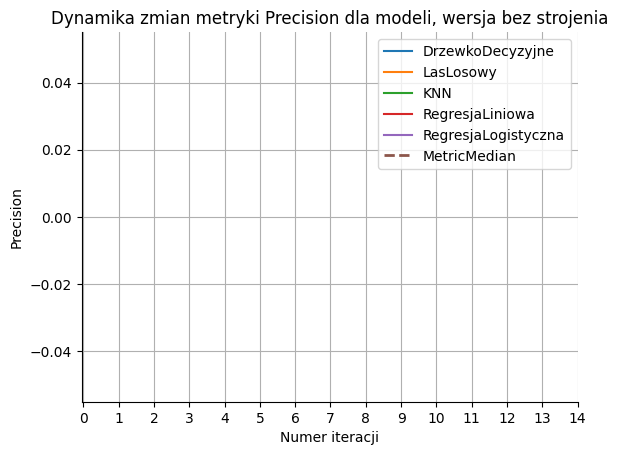

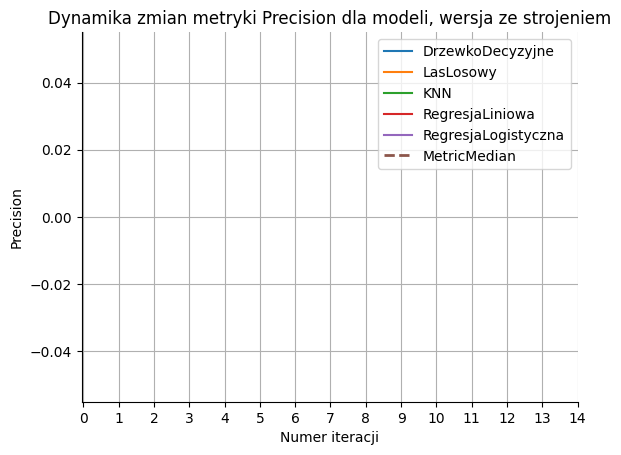

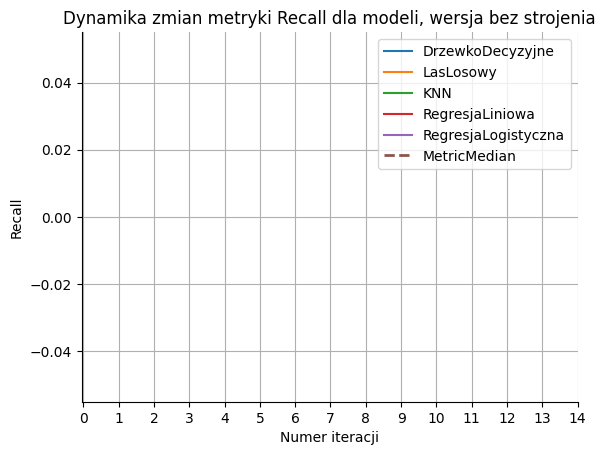

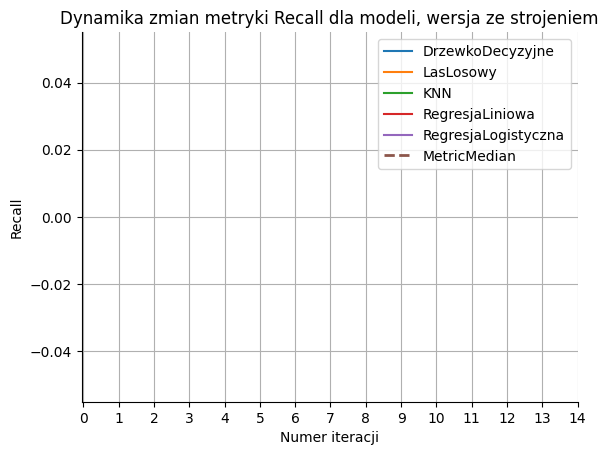

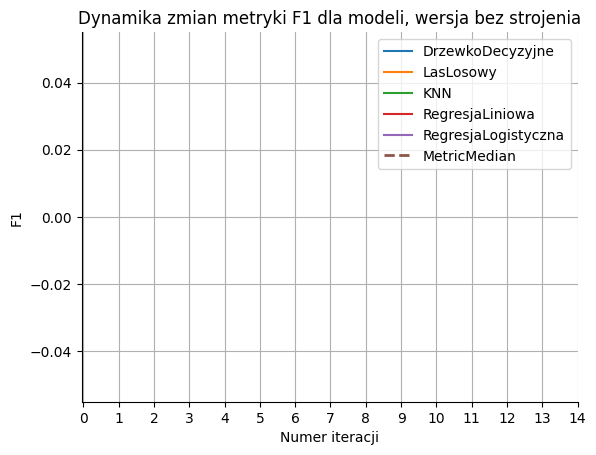

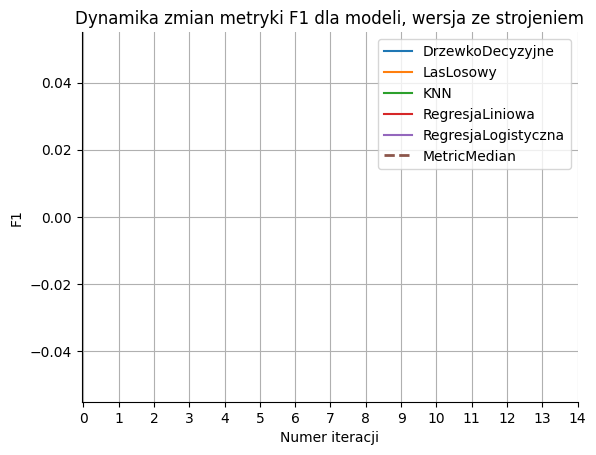

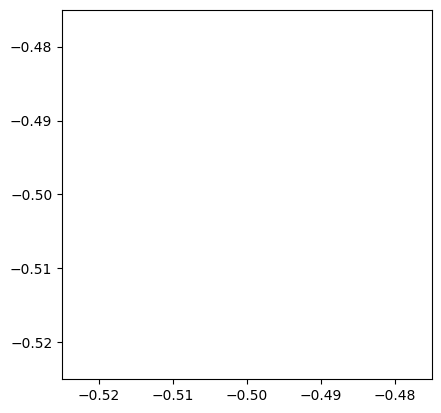

In [22]:
dtypes = { "Make": "string", #Określ typ danych każdej cechy w ramce danych.
            "Model":"string",
            "Vehicle Class":"string",
            "Engine Size(L)":np.float64,
            "Cylinders":np.int16,
            "Transmission":"string",
            "Fuel Type":"string",
            "Fuel Consumption City (L/100 km)":np.float64,
            "Fuel Consumption Hwy (L/100 km)":np.float64,
            "Fuel Consumption Comb (L/100 km)":np.float64,
            "Fuel Consumption Comb (mpg)":np.float64,
            "CO2 Emissions(g/km)":np.float64}


# Definicja modeli z hiperparametrami
Models = {
    "DrzewkoDecyzyjne": DecisionTreeClassifier(criterion="gini", splitter="best", min_samples_split=2), 
    "LasLosowy": RandomForestClassifier(n_estimators=15, criterion='gini'), 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RegresjaLiniowa": MultiOutputRegressor(estimator = LinearRegression()),
    "RegresjaLogistyczna": LogisticRegression()
}                
#Słownik do przechowywania hiperparametrów modeli:
Models_hipparams = {"DrzewkoDecyzyjne":{"criterion":['gini','entropy'],
                                       "splitter":['best','random'],
                                       "min_samples_split":[2,3],
                                        "min_samples_leaf":[2,3]},

                    "LasLosowy":{"n_estimators":list(range(5, 25, 5)),
                                  "criterion":['gini','entropy'],
                                         "min_samples_split":[2,3],
                                       "min_samples_leaf":[2,3]},
                                        
                   "KNN": {"n_neighbors":list(range(1, 10, 2)),
                            "p":[1,2]},
                            
                        "RegresjaLogistyczna": {
                            "penalty":['l2'],
                              "solver":['liblinear','newton-cg',],
                              
                         }, "RegresjaLiniowa":{}
                             }




target_var: str = "CO2 Emissions(g/km)" #To jest nazwa zmiennej docelowej.
file_name:str = "CO2Emission.csv"
n_splits:int = 15
train_size:float = 0.8
test_size:float  = 1 - train_size

WielkiEstymator = ModelsComparisom(Filename = file_name, target_var = target_var, dtypes = dtypes, 
                                  Models = Models, Models_hipparams = Models_hipparams, 
                                  n_splits = n_splits, train_size  = train_size, test_size = test_size, 
                                  bins = [-float('inf'), 150, 250, float('inf')], show_plots = False
                                  )

WielkiEstymator.StatystykaOpisowaZmiennych()
WielkiEstymator.PodzielZbiorDanych()
WielkiEstymator.PorównajModele()

In [ ]:

# Pytania badawcze przykładowe:
# 1) Jak liczba klas docelowych wpływa na skuteczność metod? Czy skuteczność modelu domyślnie maleje, jeżeli liczba klas docelowych wzrośnie?
# 2) Jak skuteczne są metody proste w porównaniu z metodami bardziej zaawansowanymi.
# 3) Jak istotne jest strojenie parametrów? Czy statyczne strojenie parametrów ulega dynamicznego strojeniu parametrów.
# 4) Jak istotny jest wybór optymalnych cech? Czy należy uwzględnić wszystkie względne? A może wystarczy tylko kilka cech?
# 5) Jak prezentuje się dokładnośc predykcji w stosunku do poszczególnych klas? Czy klasy rzadsze są łatwiej przewidywalne?
        



#Typy wyboru cech.
#1) Filtry, czyli  kasujemy cechy, niezależnie od modelu, na podstawie statystyk.
#2) wrappers, czyli metody, które są "owinięte" wokół pewnego modelu.
#3) embedded methods.


#Jak sobie poradzić ze zmiennymi kategorycznymi wysoko-kardynalnymi 
#1)Weź to przeczytaj: https://github.com/rasbt/mlxtend/issues/502

# Najpierw ustal klasy, które są determinowane przez regulacje. Będzie ich trzy
# Potem ustaw własne progi dla klas emisyjności, aby liczba klas wzrosła do 5.
# Beamer w latexu do robienia prezentacji.


Co dalej do roboty?:
2) Zamknięćie wszystkich funkcji w jedną, potężna funkcję.
4) Liczenie wskaźników dokładności, jeżeli selekcja cech była wybierana automatycznie.